In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import sklearn
import numpy as np
import matplotlib.pyplot as plt

C:\Users\JW\Anaconda3\lib\site-packages\sklearn\utils\fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


Original df shape:  (1460, 80)
Any NaN in target:  False
df shape after dropping NaN columns:  (1460, 75)


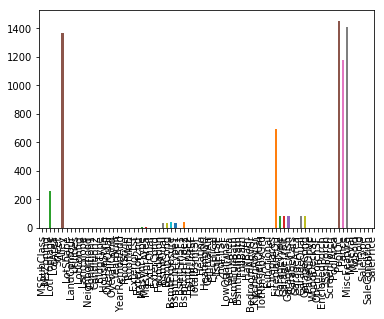

In [2]:
# Source & Data: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

path = "D:/git/House_price_predictor/"
df = pd.read_csv(os.path.join(path, 'train.csv'))
Id = df.pop('Id') # Remove the Id column
print('Original df shape: ', df.shape)
print('Any NaN in target: ', df['SalePrice'].isnull().values.any()) # Check if the target column has NaN
# Count the number of NaN in each column
na_count = df.isnull().sum()
# Visualize the count of NaN
na_count.plot.bar()
# Drop the columns with more than one third of NaN numbers
na_msk = na_count < df.shape[0]/3
df = df.loc[:,na_msk]
print('df shape after dropping NaN columns: ', df.shape)

(1460, 75)


pandas.core.series.Series

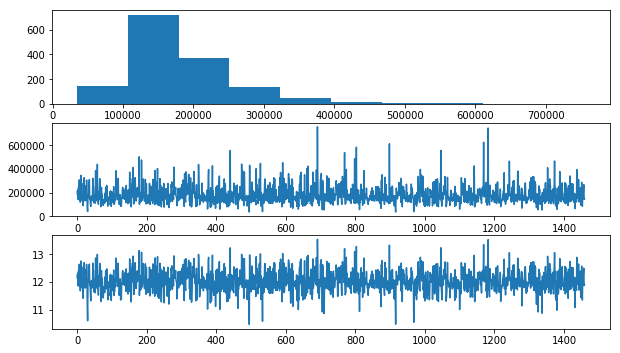

In [18]:
# Visualize the sale price
fig = plt.figure(figsize=(10,10))
num_rows = 5
ax1 = fig.add_subplot(num_rows,1,1)
ax2 = fig.add_subplot(num_rows,1,2)
ax3 = fig.add_subplot(num_rows,1,3)
print(df.shape)
log_price = np.log(df.SalePrice)

ax1.hist(df.SalePrice)
ax2.plot(df.SalePrice)
ax3.plot(log_price)

type(log_price)

In [19]:
### Find columns with non-digital element (object)
msk = df.dtypes == 'object'
colums_to_encode = df.loc[:,msk].columns.tolist()
# One hot encoding
df_encoded = pd.get_dummies(df, colums_to_encode)
print('df shape after one-hot encoding: ', df_encoded.shape)

df shape after one-hot encoding:  (1460, 271)


In [20]:
# Define X and y for the model input
y = df_encoded.pop('SalePrice').values
X = df_encoded.values
print('Shape of X: ', np.shape(X))
print('Shape of y: ', np.shape(y))

Shape of X:  (1460, 270)
Shape of y:  (1460,)


In [21]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
y_train_log = np.log(y_train)
X_train, X_val, y_train_log, y_val_log = train_test_split(X_train, y_train_log, test_size=0.25)
print('Train set size: ', X_train.shape)
print('Validation set size: ', X_val.shape)
print('Test set size: ', X_test.shape)

Train set size:  (876, 270)
Validation set size:  (292, 270)
Test set size:  (292, 270)


In [22]:
# Purify the data/ Handle NaN
from sklearn.impute import SimpleImputer
my_imputer = SimpleImputer()
X_train = my_imputer.fit_transform(X_train)
X_val = my_imputer.transform(X_val)
X_test = my_imputer.transform(X_test)

In [8]:
def mapeobj(preds, labels):
    # Positive error: preds[i] >= labels[i]
    # Negative error: preds[i] < labels[i]
    # Loss funtion: J = 1/N * sum(sign(preds-labels)/lebel)
    beta = 5
    # Define a "bias mask" which gives larger weight for Negative errors (preds[i] < labels[i]).
    msk_bias = [1.0/beta if preds[i]-labels[i] >= 0 else beta for i in range(len(labels))]
    # 1st order gradient
    grad = np.sign(preds-labels)*msk_bias*1.0/labels/len(labels)
    hess = 0*np.ones(len(preds))
    return grad, hess

def evalmape(preds,labels):
    beta = 5
    msk_bias = [1.0/beta if preds[i]-labels[i] >= 0 else beta for i in range(len(labels))]
    error = sum(abs(preds-labels)*msk_bias*1.0/(labels))*1.0/len(labels)
    num_pos_err = sum(1 for entry in msk_bias if entry == 1.0/beta)
    num_neg_err = sum(1 for entry in msk_bias if entry == beta)
    return error, num_pos_err, num_neg_err

In [9]:
# Scikit-learn API
from xgboost import XGBRegressor
# Give larger weight to more recent data based on df.YrSold
sample_weights_data = 1 + (df.YrSold - 2010) * 10 * 0.01
my_model = XGBRegressor(n_estimators=1000, obj=mapeobj, feval=evalmape)
# Add silent=True to avoid printing out updates with each cycle
my_model.fit(X_train, y_train_log, 
             sample_weight=sample_weights_data, 
             early_stopping_rounds=5, 
             eval_set=[(X_val, y_val_log)], 
             verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, feval=<function evalmape at 0x00000213FD0F90D0>,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, obj=<function mapeobj at 0x00000213FD0F9048>,
       objective='reg:linear', random_state=0, reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=None, silent=True, subsample=1)

<BarContainer object of 10 artists>

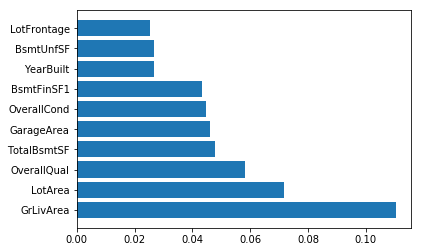

In [10]:
# Check the feature importances
features = df_encoded.columns.values.tolist()
importances = my_model.feature_importances_
feature_importances = pd.Series(importances, index = features)
feature_importances.sort_values(ascending=False, inplace=True)
# Plot the first 10 important features
plt.barh(feature_importances.index[:10], feature_importances[:10])

In [11]:
# make predictions
predictions = my_model.predict(X_test)

from sklearn.metrics import mean_absolute_error
print("Mean Absolute Error: ", mean_absolute_error(np.exp(predictions), y_test))
print("Mean Absolute Percentage Error: ", evalmape(np.exp(predictions), y_test)[0])
print("Positive Error (preds >= label): ", evalmape(np.exp(predictions), y_test)[1])
print("Negative Error (preds < label): ", evalmape(np.exp(predictions), y_test)[2])

Mean Absolute Error:  19147.2730763
Mean Absolute Percentage Error:  0.219606717987
Positive Error (preds >= label):  147
Negative Error (preds < label):  145


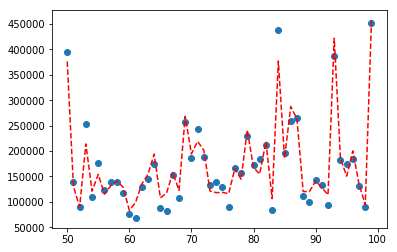

In [12]:
# Visualize the data and predictions
num_to_plot = 100
Id_test = np.arange(len(y_test))
plt.scatter(Id_test[50:num_to_plot], y_test[50:num_to_plot])
plt.plot(Id_test[50:num_to_plot], np.exp(predictions[50:num_to_plot]), c='r', ls='--')

In [13]:
# Generate house data which was sold in 2010
df_test = pd.DataFrame(X_test, columns=df_encoded.columns.values)
msk_2010 = df_test.YrSold == 2010
predictions_2010 = predictions[msk_2010]
y_test_2010 = y_test[msk_2010]
# Generate house data which was sold in 2006
msk_2006 = df_test.YrSold == 2006
predictions_2006 = predictions[msk_2006]
y_test_2006 = y_test[msk_2006]

Mean Absolute Percentage Error (2006):  0.252539263454
Positive Error (preds >= label):  21
Negative Error (preds < label):  33


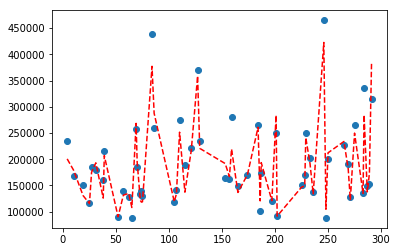

In [14]:
# Visualize house data and predictions for 2006
Id_2006 = Id_test[msk_2006]
plt.scatter(Id_2006, y_test_2006)
plt.plot(Id_2006, np.exp(predictions_2006), c='r', ls='--')
print("Mean Absolute Percentage Error (2006): ", evalmape(np.exp(predictions_2006), y_test_2006)[0])
print("Positive Error (preds >= label): ", evalmape(np.exp(predictions_2006), y_test_2006)[1])
print("Negative Error (preds < label): ", evalmape(np.exp(predictions_2006), y_test_2006)[2])

Mean Absolute Percentage Error (2010):  0.193475363184
Positive Error (preds >= label):  18
Negative Error (preds < label):  19


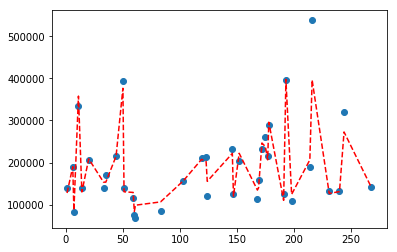

In [15]:
# Visualize house data and predictions for 2006
Id_2010 = Id_test[msk_2010]
plt.scatter(Id_2010, y_test_2010)
plt.plot(Id_2010, np.exp(predictions_2010), c='r', ls='--')
print("Mean Absolute Percentage Error (2010): ", evalmape(np.exp(predictions_2010), y_test_2010)[0])
print("Positive Error (preds >= label): ", evalmape(np.exp(predictions_2010), y_test_2010)[1])
print("Negative Error (preds < label): ", evalmape(np.exp(predictions_2010), y_test_2010)[2])

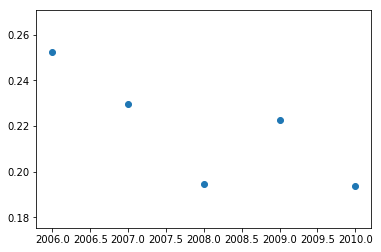

In [16]:
# Calculate mape for individual years
union_yr = list(set(df_test.YrSold.values))
union_yr.sort
mape_yr = []
for yr in union_yr:
    msk_yr = df_test.YrSold == yr
    mape_yr.append(evalmape(np.exp(predictions[msk_yr]), y_test[msk_yr])[0])

plt.scatter(union_yr, mape_yr)

In [17]:
# ###### XGB API ############
# #############################
# import xgboost as xgb
# import xgboost as xgb

# dtrain = xgb.DMatrix(X_train, label=y_train, weight=None)
# dval = xgb.DMatrix(X_val, label=y_val, weight=None)
# watchlist = [(dval, 'eval'), (dtrain, 'train')]

# dtrain = xgb.DMatrix(X_train, label=y_train, weight=None)
# dval = xgb.DMatrix(X_val, label=y_val, weight=None)
# watchlist = [(dval, 'eval'), (dtrain, 'train')]

# param = {'max_depth': 2, 
#          'eta': 1, 
#          'silent': 1,
#          'n_estimators':1000}
# bst = xgb.train(params=param, dtrain=dtrain, evals=watchlist, 
#               obj=mapeobj, 
#               feval=evalmape,
#               early_stopping_rounds=5, 
#               verbose_eval=True)

# ##########################3